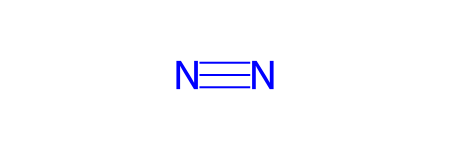

In [1]:
import rdkit
from rdkit.Chem import AllChem
import psi4
import numpy as np
from matplotlib import pyplot as plt

n2 = rdkit.Chem.MolFromSmiles("N#N")
AllChem.EmbedMolecule(n2)
n2

In [ ]:
print(rdkit.Chem.MolToXYZBlock(n2))

In [ ]:
psi4.set_memory('4096 MB')
psi4.core.set_output_file('n2.txt',False)
n2_p4 = psi4.geometry(rdkit.Chem.MolToXYZBlock(n2))

In [ ]:
psi4.energy('B3LYP/6-311G**',molecule = n2_p4)

In this cell, we're specifying the geometry of the molecule using a [Z-matrix](https://gaussian.com/zmat/).

In [ ]:
x = np.linspace(0.6,5,30)
hfegy = []
calc = 'HF/3-21G'

psi4.core.set_output_file('n2-pec-hf-321g.txt',False)

for R in x:
    n2_p4 = psi4.geometry(f"""
    N
    N 1 {R}
    """)
    
    hfegy.append(psi4.energy(calc,molecule=n2_p4))
    
fig, ax = plt.subplots()
ax.plot(x,hfegy,marker='o',linestyle='solid')
ax.set_xlabel(r'N-N Bond length ($\AA$)')
ax.set_ylabel('Energy (Hartree)')

In [ ]:
x = np.linspace(0.6,5,30)
b3lypegy = []
calc = 'B3LYP/3-21G'

psi4.core.set_output_file('n2-pec-b3lyp-321g.txt',False)
count = 1
for R in x:
    print(f'Performing calculation {count}/{len(x)}')
    count +=1
    n2_p4 = psi4.geometry(f"""
    N
    N 1 {R}
    """)
    
    b3lypegy.append(psi4.energy(calc,molecule=n2_p4))
    
fig, ax = plt.subplots()
ax.plot(x,b3lypegy,marker='o',linestyle='solid',label='B3LYP/3-21G')
ax.plot(x,hfegy,marker='o',linestyle='solid',label='HF/3-21G')
ax.set_xlabel(r'N-N Bond length ($\AA$)')
ax.set_ylabel('Energy (Hartree)')
ax.legend()

In [ ]:
x = np.linspace(0.6,5,30)
b3lypegy2 = []
calc = 'B3LYP/6-31G*'

psi4.core.set_output_file('n2-pec-b3lyp-631gs.txt',False)
count = 1
for R in x:
    print(f'Performing calculation {count}/{len(x)}')
    count +=1
    n2_p4 = psi4.geometry(f"""
    N
    N 1 {R}
    """)
    
    b3lypegy2.append(psi4.energy(calc,molecule=n2_p4))
    
fig, ax = plt.subplots()
ax.plot(x,b3lypegy,marker='o',linestyle='solid',label='B3LYP/3-21G')
ax.plot(x,hfegy,marker='o',linestyle='solid',label='HF/3-21G')
ax.plot(x,b3lypegy2,marker='o',linestyle='solid',label='B3LYP/6-31G*')
ax.set_xlabel(r'N-N Bond length ($\AA$)')
ax.set_ylabel('Energy (Hartree)')
ax.legend()

How do we find out what the optimized structure is?

In [ ]:
calc = 'B3LYP/6-31G*'
psi4.core.set_output_file('n2-opt-b3lyp-631gs.txt',False)

#pick a starting geometry (use rdkit value)
n2_geo = psi4.geometry(rdkit.Chem.MolToXYZBlock(n2))

#perform optimization with psi4.optimize
egy = psi4.optimize(calc,molecule=n2_geo)

#these functions will print things to the output file
n2_geo.print_distances()
n2_geo.print_bond_angles()

#this returns an acual matrix in units of Bohr
print(n2_geo.distance_matrix().to_array())

#convert to Angstrom
print(n2_geo.distance_matrix().to_array()*psi4.constants.bohr2angstroms)

In [ ]:
egy

In [ ]:
psi4.core.set_output_file('n2-freq-b3lyp-631gs.txt',False)

#This version of psi4 has a bug! B3LYP frequency calculations don't work :(
psi4.frequency(calc,molecule=n2_geo)

In [ ]:
calc = 'HF/6-31G*'
psi4.core.set_output_file('n2-opt-hf-631gs.txt',False)

#A frequency calculation must start from an optimized geometry at the same level of theory.
n2_geo = psi4.geometry(rdkit.Chem.MolToXYZBlock(n2))
egy = psi4.optimize(calc,molecule=n2_geo)

#Hartree-Fock frequency calculations do work
#Prof. Wang reported this problem as a bug, and it should be fixed in an upcoming release.
psi4.frequency(calc,molecule=n2_geo)

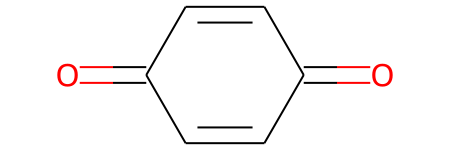

In [2]:
# Now let's look at a larger molecule, bonzoquinone
m1 = rdkit.Chem.MolFromSmiles('C1=CC(=O)C=CC1=O')
m1

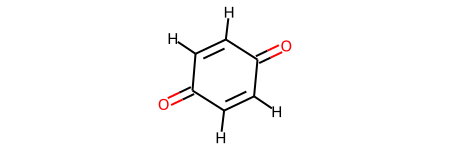

In [3]:
#add H atoms, embed, visualize
m1 = rdkit.Chem.AddHs(m1)
AllChem.EmbedMolecule(m1)
m1

In [4]:
import nglview
nglview.show_rdkit(m1)

NGLWidget()

In [5]:
bq = psi4.geometry(rdkit.Chem.MolToXYZBlock(m1))
psi4.core.set_output_file('bq-egy-b3lyp-631gs.txt')
calc = 'B3LYP/6-31G*'
egy = psi4.energy(calc,molecule=bq)
egy

-381.4448985727553

In [6]:
psi4.core.set_output_file('bq-opt-b3lyp-631gs.txt')
calc = 'B3LYP/6-31G*'
optegy = psi4.optimize(calc,molecule=bq)
optegy

Optimizer: Optimization complete!


-381.45160293097484

In [7]:
print(abs(egy-optegy)*psi4.constants.hartree2kcalmol)

4.207048298375445


In [24]:
#get optimized structure into rdkit... not as straightforward as it might seem!
#the xyz coordinates don't contain bonding information, which rdkit requires to construct the molecular graph
#however, as long as we initialize the psi4 calculation with an rdkit XYZBlock
#we can simply replace the coordinates with the optimized ones, because the atoms will be in the same order

#get geometry, and reshape it into an Nx3 array
psi4_geom = bq.to_dict()['geom'].reshape(-1,3)

from rdkit.Chem import rdchem

#create a new version of the molecule
m2 = rdkit.Chem.MolFromSmiles('C1=CC(=O)C=CC1=O')
m2 = rdkit.Chem.AddHs(m2)
AllChem.EmbedMolecule(m2)
conf = m2.GetConformer(0)
for i in range(m2.GetNumAtoms()):
    conf.SetAtomPosition(i,psi4_geom[i])
    
#add this as a second conformer to the molecule, then remove the original
m2.AddConformer(conf,assignId=True)
m2.RemoveConformer(0)
nglview.show_rdkit(m2)

NGLWidget()

In [22]:
#Compute RMSD of the optimized structure with the conformer generated by rdkit
rdkit.Chem.rdMolAlign.AlignMol(m1, m2)

0.030785102479519093